# LSTM Pipeline for Racing Line Prediction

In [1]:
# Quick check to ensure model will run on GPU
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

2.6.0+cu126
CUDA available: True
Device: NVIDIA GeForce GTX 1080


In [2]:
# === Imports ===
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
import torch.serialization
torch.serialization.add_safe_globals([MinMaxScaler])
import matplotlib.pyplot as plt

In [3]:
# === Configuration ===

# First Run Config
# config = {
#     "seed": 42,
#     "input_size": 6,
#     "output_size": 23,
#     "train_split": 0.8,
#     "num_epochs": 50,
#     "learning_rate": 0.001,
#     "batch_size": 64,
#     "hidden_size": 128,
#     "num_layers": 2,
#     "dropout": 0.2,
#     "seq_len": 50,
#     "patience": 10,
#     "pin_memory": True,
#     "bidirectional": True,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "train_data_path": "./data/extracted_track_data/",
#     "model_save_path": "./models/racing_line_lstm.pt",
#     "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
#     "output_cols": ["x","y","z","length","id","speed","gas","brake","obsolete_lat_g","radius","side_left","side_right","camber",
#                     "direction","normal_x","normal_y","normal_z","extra_length","forward_x","forward_y","forward_z","tag","grade"]
# }

# Long Run Config
# config = {
#     "seed": 42,
#     "input_size": 6,
#     "output_size": 23,
#     "train_split": 0.8,
#     "num_epochs": 200,
#     "learning_rate": 0.0005,
#     "batch_size": 64,
#     "hidden_size": 512,
#     "num_layers": 4,
#     "dropout": 0.1,
#     "seq_len": 50,
#     "patience": 25,
#     "pin_memory": True,
#     "bidirectional": True,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "train_data_path": "./data/extracted_track_data/",
#     "model_save_path": "./models/seven_feat_racing_line_lstm.pt",
#     "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
#     "output_cols": ["x","y","z","length","id","speed","gas","brake","obsolete_lat_g","radius","side_left","side_right","camber",
#                     "direction","normal_x","normal_y","normal_z","extra_length","forward_x","forward_y","forward_z","tag","grade"]
# }

# Less target features still big model but less epochs
# config = {
#     "seed": 42,
#     "input_size": 6,
#     "output_size": 7,
#     "train_split": 0.8,
#     "num_epochs": 50,
#     "learning_rate": 0.0005,
#     "batch_size": 64,
#     "hidden_size": 512,
#     "num_layers": 4,
#     "dropout": 0.1,
#     "seq_len": 50,
#     "patience": 25,
#     "pin_memory": True,
#     "bidirectional": True,
#     "device": "cuda" if torch.cuda.is_available() else "cpu",
#     "train_data_path": "./data/extracted_track_data/",
#     "model_save_path": "./models/seven_feat_racing_line_lstm.pt",
#     "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
#     "output_cols": ["x","y","z","gas","brake","side_left","side_right"]
# }

#Testing config
config = {
    "seed": 42,
    "input_size": 6,
    "output_size": 3,
    "train_split": 0.8,
    "num_epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 64,
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.2,
    "seq_len": 50,
    "patience": 10,
    "pin_memory": True,
    "bidirectional": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "train_data_path": "./data/extracted_track_data/",
    "test_data_path": "./data/testing_layouts/",
    "model_save_path": "./models/testing_racing_line_lstm.pt",
    "input_cols": ["left_x","left_y","left_z","right_x","right_y","right_z"],
    "output_cols": ["x","y","z"]
}

random.seed(config["seed"])
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
torch.cuda.manual_seed(config["seed"])
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# === Dataset ===
class RacingLineDataset(Dataset):
    def __init__(self, train_data_path, test_data_path, seq_len):
        self.inputs, self.targets = [], []
        self.seq_len = seq_len
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        all_X, all_Y = [], []
        train_files = sorted(glob(os.path.join(train_data_path, "*.csv")))
        test_files = sorted(glob(os.path.join(test_data_path, "*.csv")))

        # === First pass: Collect data for global fitting ===
        for file in train_files:
            df = pd.read_csv(file)
            X = df[config["input_cols"]].values
            Y = df[config["output_cols"]].values
            all_X.append(X)
            all_Y.append(Y)
        for file in test_files:
            df = pd.read_csv(file)
            X = df[config["input_cols"]].values
            Y = df[config["output_cols"]].values
            all_X.append(X)
            all_Y.append(Y)
        all_X = np.vstack(all_X)
        all_Y = np.vstack(all_Y)
        self.scaler_x.fit(all_X)
        self.scaler_y.fit(all_Y)

        # === Second pass: Normalize and extract sequences ===
        for file in train_files:
            df = pd.read_csv(file)
            X = self.scaler_x.transform(df[config["input_cols"]].values)
            Y = self.scaler_y.transform(df[config["output_cols"]].values)

            for i in range((len(X) - seq_len) + 1):
                self.inputs.append(X[i:i+seq_len])
                self.targets.append(Y[i+seq_len-1])

        # Convert to tensors
        self.inputs = torch.tensor(np.array(self.inputs), dtype=torch.float32)
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [5]:
# === Model with Attention ===
class RacingLineLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 num_layers=2, dropout=0.2, bidirectional=False,
                 scaler_x=None, scaler_y=None):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidirectional
        )

        self.attn = nn.Linear(self.num_directions * hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.num_directions * hidden_size, output_size)

        # Optional scalers for external inference use
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden * directions)

        # Compute attention scores over time steps
        attn_scores = self.attn(lstm_out)  # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)  # (batch, seq_len, 1)

        # Apply attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden * directions)

        # Apply dropout to context vector
        context = self.dropout(context)

        return self.fc(context)  # (batch, output_size)

    def get_attention_weights(self, x):
        """Optional: for visualization/debugging"""
        lstm_out, _ = self.lstm(x)
        attn_scores = self.attn(lstm_out)
        attn_weights = torch.softmax(attn_scores, dim=1)
        return attn_weights.squeeze(-1)  # (batch, seq_len)

In [6]:
# === Evaluation Function ===
def evaluate_model(model, dataloader, criterion, config):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in dataloader:
            X_batch, Y_batch = X_batch.to(config["device"]), Y_batch.to(config["device"])
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [7]:
# === Save and Load Model (with architecture) ===
def save_model(model, config, scaler_x, scaler_y):
    torch.save({
        "model_state_dict": model.state_dict(),
        "config": config,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
    }, config["model_save_path"])

def load_model(path):
    checkpoint = torch.load(path, map_location=config["device"], weights_only=False)
    cfg = checkpoint["config"]
    model = RacingLineLSTMWithAttention(cfg["input_size"], cfg["hidden_size"],
                                        cfg["output_size"], cfg["num_layers"],
                                        cfg["dropout"], cfg["bidirectional"])
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(cfg["device"])
    model.eval()
    return model, checkpoint["scaler_x"], checkpoint["scaler_y"]

In [8]:
# === Training Function (with tqdm and validation) ===
def train_model(model, train_loader, val_loader, config, scaler_x, scaler_y):
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    early_stopping_patience = config["patience"]
    epochs_without_improvement = 0
    best_epoch = 0

    obar = tqdm(range(config["num_epochs"]), desc="Epochs")
    for epoch in obar:
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}", leave=False)
        for X_batch, Y_batch in pbar:
            X_batch, Y_batch = X_batch.to(config["device"]), Y_batch.to(config["device"])
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({"Loss": running_loss / (pbar.n + 1)})

        train_losses.append(running_loss / len(train_loader))
        val_loss = evaluate_model(model, val_loader, criterion, config)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config, scaler_x, scaler_y)
            best_epoch = epoch+1
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        obar.set_postfix({"Train Loss": running_loss/len(train_loader), "Val Loss": val_loss, "Lr": scheduler.get_last_lr()[0], "best_epoch": best_epoch})

        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return train_losses, val_losses


In [ ]:
# === Full Pipeline ===
def run_pipeline(train_data_path=config["train_data_path"], test_data_path=config["test_data_path"]):
    print("Preparing dataset...")
    full_dataset = RacingLineDataset(
        train_data_path,
        test_data_path,
        config["seq_len"],
    )
    scaler_x = full_dataset.scaler_x
    scaler_y = full_dataset.scaler_y
    print("Total sequences loaded:", len(full_dataset))

    # === 80/20 train/val split with reproducibility ===
    train_len = int(len(full_dataset) * config["train_split"])
    val_len = len(full_dataset) - train_len
    train_ds, val_ds = random_split(
        full_dataset,
        [train_len, val_len],
        generator=torch.Generator().manual_seed(config["seed"])
    )

    train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=False, pin_memory=config["pin_memory"])
    val_loader = DataLoader(val_ds, batch_size=config["batch_size"], shuffle=False, pin_memory=config["pin_memory"])

    print("Initializing model...")
    model = RacingLineLSTMWithAttention(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["output_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        bidirectional=config["bidirectional"]
    ).to(config["device"])

    print("Training started...")
    train_losses, val_losses = train_model(model, train_loader, val_loader, config, scaler_x, scaler_y)
    print(f"Training complete. Model saved to {config['model_save_path']}")

    # === Plot learning curve ===
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
    

Preparing dataset...
Total sequences loaded: 132945
Initializing model...
Training started...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/1662 [00:00<?, ?it/s]

Training complete. Model saved to ./models/testing_racing_line_lstm.pt


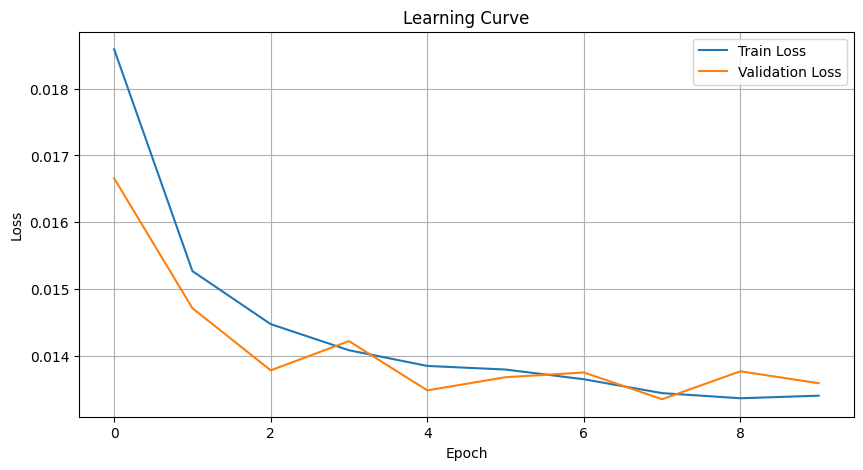

In [10]:
# === Train Model ===
run_pipeline()

Loading model and scalers...
Loading unseen layouts from: ./data/testing_layouts
Found 1 layout files.

[1/1] Predicting layout: ks_barcelona_layout_gp_Processed_Data.csv


[1/1]:   0%|          | 0/2878 [00:00<?, ?it/s]

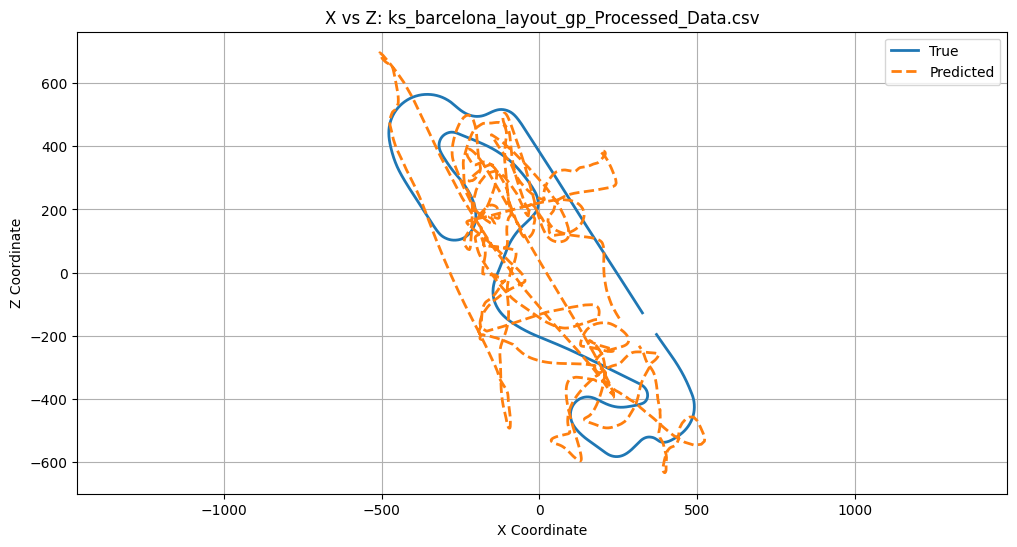


Per-Feature Accuracy (%):
------------------------------------------------------------
               x:  89.10% (layout-based)     0.00% (train-scale)
               y:  83.88% (layout-based)     0.00% (train-scale)
               z:  88.19% (layout-based)     0.00% (train-scale)
Mean X/Z spatial error: 184.07m, Max: 1129.38m



In [11]:
# === Inference on Testing Track Layouts (from coordinates only, doesnt take image for inference) ===
def print_feature_accuracy(preds, trues, scaler_y, feature_names):
    preds = np.array(preds)
    trues = np.array(trues)

    print(f"\nPer-Feature Accuracy (%):")
    print("-" * 60)
    for i, name in enumerate(feature_names):
        range_train = scaler_y.scale_[i]
        range_test = trues[:, i].max() - trues[:, i].min()

        if range_test == 0:
            print(f"{name:>16}: N/A (zero test range)")
            continue

        mean_error = np.mean(np.abs(preds[:, i] - trues[:, i]))
        acc_train = (1 - (mean_error / range_train)) * 100
        acc_test = (1 - (mean_error / range_test)) * 100

        acc_train = max(0.0, min(100.0, acc_train))
        acc_test = max(0.0, min(100.0, acc_test))

        print(f"{name:>16}: {acc_test:6.2f}% (layout-based)   {acc_train:6.2f}% (train-scale)")

def run_inference(data_folder, model_path):
    print("Loading model and scalers...")
    model, scaler_x, scaler_y = load_model(model_path)

    print("Loading unseen layouts from:", data_folder)
    layout_files = sorted(glob(os.path.join(data_folder, "*.csv")))
    total_layouts = len(layout_files)
    print(f"Found {total_layouts} layout files.\n")

    for layout_index, layout_path in enumerate(layout_files):
        layout_name = os.path.basename(layout_path)
        print(f"[{layout_index + 1}/{total_layouts}] Predicting layout: {layout_name}")

        df = pd.read_csv(layout_path)
        X = df[config["input_cols"]].values
        Y = df[config["output_cols"]].values
        X_scaled = scaler_x.transform(X)

        preds_real = []
        trues_real = []

        layout_windows = len(X_scaled) - config["seq_len"]

        for i in tqdm(range(layout_windows), desc=f"[{layout_index + 1}/{total_layouts}]"):
            X_window = X_scaled[i:i+config["seq_len"]].reshape(1, config["seq_len"], -1)
            X_tensor = torch.tensor(X_window, dtype=torch.float32).to(config["device"])

            with torch.no_grad():
                pred_scaled = model(X_tensor).cpu().squeeze().numpy()
                pred_real = scaler_y.inverse_transform(pred_scaled.reshape(1, -1))[0]
                true_real = Y[i+config["seq_len"]-1]

            preds_real.append(pred_real)
            trues_real.append(true_real)

        preds_real = np.array(preds_real)
        trues_real = np.array(trues_real)

        # === Plot X/Z comparison ===
        plt.figure(figsize=(12, 6))
        plt.plot(trues_real[:, 0], trues_real[:, 2], label="True", linewidth=2)
        plt.plot(preds_real[:, 0], preds_real[:, 2], label="Predicted", linewidth=2, linestyle="--")
        plt.title(f"X vs Z: {layout_name}")
        plt.xlabel("X Coordinate")
        plt.ylabel("Z Coordinate")
        plt.axis("equal")
        plt.grid(True)
        plt.legend()
        plt.show()

        # === Accuracy ===
        print_feature_accuracy(preds_real, trues_real, scaler_y, config["output_cols"])

        # === Spatial Error (X/Z only)
        spatial_errors = np.linalg.norm(preds_real[:, [0, 2]] - trues_real[:, [0, 2]], axis=1)
        mean_spatial_error = np.mean(spatial_errors)
        max_spatial_error = np.max(spatial_errors)
        print(f"Mean X/Z spatial error: {mean_spatial_error:.2f}m, Max: {max_spatial_error:.2f}m\n")


# === Run it ===
run_inference(data_folder="./data/testing_layouts", model_path="./models/seven_feat_racing_line_lstm.pt")